# In-session Recommendation in eCommerce
> Training prod2vec model on a small sample of coveo sigir21 retail dataset and covering cold-start as well as search query scoping scenarios

- toc: true
- badges: true
- comments: true
- categories: [ColdStart, Session, Sequential, Retail, Coveo, Prod2vec, Annoy, Keras, Embedding, Visualization, TSNE, Search, QueryScoping]
- image:

| |  |
| :-: | -:|
| Vision | Improve customer's in-session experience |
| Mission | Improve search, learn better product embeddings, Effectively address the cold-start scenario|
| Scope | Model training and validation, Multi-modality, Search-based personalization, In-session recommendations |
| Task | Next-item Prediction, Cold-start Scenario, Search Query Scoping |
| Data | Coveo |
| Tool | Gensim, Keras, Colab, Python, Annoy |
| Technique | Improve search with query scoping technique, learn better product embeddings using prod2vec, Effectively address the cold-start scenario using multi-stage KNN scoring |
| Process | 1) Load data using recochef, 2) Build prod2vec model, 3) Improve low-count vectors to address cold-start, 4) Query scoping system |
| Takeaway | Prod2vec is simple yet effective model as can be seen in TSNE plot, Cold-start can be improved with strategies like we have seen in this case, query scoping is relevant |
| Credit | [Jacopo Tagliabue](https://github.com/jacopotagliabue) |
| Link | [link1](https://github.com/jacopotagliabue/retail-personalization-workshop), [link2](https://dl.acm.org/doi/10.1145/3366424.3386198) |

## Environment setup

In [ ]:
!pip install gensim==4.0.1 keras==2.4.3 pydot==1.4.2 graphviz==0.16 annoy==1.17.0
!pip install git+https://github.com/sparsh-ai/recochef

In [2]:
import os
from random import choice
import time
import ast
import json
import numpy as np
import pandas as pd
import csv
from collections import Counter,defaultdict
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from IPython.display import Image 
import gensim
from gensim.similarities.annoy import AnnoyIndexer
from sklearn.model_selection import train_test_split
import hashlib
from copy import deepcopy

from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Concatenate
from keras.models import Sequential
from keras.layers import Input
from keras.optimizers import SGD, Adam
from keras.models import Model
from keras import utils
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model

from recochef.datasets.coveo import Coveo

In [3]:
%matplotlib inline

In [126]:
!pip install -q watermark
%reload_ext watermark
%watermark -m -iv

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

IPython   : 5.5.0
pandas    : 1.1.5
json      : 2.0.9
keras     : 2.4.3
matplotlib: 3.2.2
numpy     : 1.19.5
csv       : 1.0
gensim    : 4.0.1



## Data loading

In [4]:
coveo_data = Coveo()

In [5]:
browsing_data = coveo_data.load_browsing_events()
browsing_data.head()

,SESSIONID,EVENTTYPE,ACTIONTYPE,ITEMID,TIMESTAMP,URLID
0,0.0,0.0,0.0,0.0,1550885210881,0.0
1,0.0,0.0,0.0,1.0,1550885213307,1.0
2,0.0,1.0,NaN,NaN,1550885213307,1.0
3,0.0,0.0,0.0,0.0,1550885215484,0.0
4,0.0,1.0,NaN,NaN,1550885215484,0.0


In [6]:
labels = coveo_data.load_labels()
labels.keys()

dict_keys(['session_id_hash', 'event_type', 'product_action', 'product_sku_hash', 'hashed_url', 'category_hash'])

In [7]:
browsing_data.columns

Index(['SESSIONID', 'EVENTTYPE', 'ACTIONTYPE', 'ITEMID', 'TIMESTAMP', 'URLID'], dtype='object')

In [8]:
browsing_data.head()

,SESSIONID,EVENTTYPE,ACTIONTYPE,ITEMID,TIMESTAMP,URLID
0,0.0,0.0,0.0,0.0,1550885210881,0.0
1,0.0,0.0,0.0,1.0,1550885213307,1.0
2,0.0,1.0,NaN,NaN,1550885213307,1.0
3,0.0,0.0,0.0,0.0,1550885215484,0.0
4,0.0,1.0,NaN,NaN,1550885215484,0.0


In [116]:
inverse_action_map = {v:k for k,v in labels['product_action'].items()}
browsing_data['ACTIONTYPE'] = browsing_data['ACTIONTYPE'].map(inverse_action_map)

inverse_event_map = {v:k for k,v in labels['event_type'].items()}
browsing_data['EVENTTYPE'] = browsing_data['EVENTTYPE'].map(inverse_event_map)

inverse_session_map = {v:k for k,v in labels['session_id_hash'].items()}
browsing_data['SESSIONID'] = browsing_data['SESSIONID'].map(inverse_session_map)

inverse_item_map = {v:k for k,v in labels['product_sku_hash'].items()}
browsing_data['ITEMID'] = browsing_data['ITEMID'].map(inverse_item_map.get, na_action='ignore')

inverse_url_map = {v:k for k,v in labels['hashed_url'].items()}
browsing_data['URLID'] = browsing_data['URLID'].map(inverse_url_map)

browsing_data.columns = ['session_id_hash','event_type','product_action',
                         'product_sku_hash','server_timestamp_epoch_ms', 'hashed_url']

browsing_data.head()

,session_id_hash,event_type,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url
0,20c458b802f6ea9374783bfc528b19421be977a6769785...,event_product,detail,d5157f8bc52965390fa21ad5842a8502bc3eb8b0930f3f...,1550885210881,7e4527ac6a32deed4f4f06bb7c49b907b7ca371e59d57d...
1,20c458b802f6ea9374783bfc528b19421be977a6769785...,event_product,detail,61ef3869355b78e11011f39fc7ac8f8dfb209b3442a9d5...,1550885213307,4ed279f4f0deab6dfc80f4f7bf49d527fd894fa478a9ce...
2,20c458b802f6ea9374783bfc528b19421be977a6769785...,pageview,NaN,NaN,1550885213307,4ed279f4f0deab6dfc80f4f7bf49d527fd894fa478a9ce...
3,20c458b802f6ea9374783bfc528b19421be977a6769785...,event_product,detail,d5157f8bc52965390fa21ad5842a8502bc3eb8b0930f3f...,1550885215484,7e4527ac6a32deed4f4f06bb7c49b907b7ca371e59d57d...
4,20c458b802f6ea9374783bfc528b19421be977a6769785...,pageview,NaN,NaN,1550885215484,7e4527ac6a32deed4f4f06bb7c49b907b7ca371e59d57d...


## Build a prod2vec space

Know more - [blog](https://blog.coveo.com/clothes-in-space-real-time-personalization-in-less-than-100-lines-of-code/), [paper](https://arxiv.org/abs/2104.02061)

In [10]:
N_ROWS = 500000  # how many rows we want to take (to avoid waiting too much for tutorial purposes)?

In [14]:
def read_sessions_from_training_file(df: pd.DataFrame):
    """
    Read the training file containing product interactions, up to K rows.
    
    :return: a list of lists, each list being a session (sequence of product IDs)
    """
    user_sessions = []
    current_session_id = None
    current_session = []
    for idx, row in df.iterrows():
        # just append "detail" events in the order we see them
        # row will contain: session_id_hash, product_action, product_sku_hash
        _session_id_hash = row['session_id_hash']
        # when a new session begins, store the old one and start again
        if current_session_id and current_session and _session_id_hash != current_session_id:
            user_sessions.append(current_session)
            # reset session
            current_session = []
        # check for the right type and append
        if row['product_action'] == 'detail':
            current_session.append(row['product_sku_hash'])
        # update the current session id
        current_session_id = _session_id_hash

    # print how many sessions we have...
    print("# total sessions: {}".format(len(user_sessions)))

    return user_sessions

In [15]:
def train_product_2_vec_model(sessions: list,
                              min_c: int = 3,
                              size: int = 48,
                              window: int = 5,
                              iterations: int = 15,
                              ns_exponent: float = 0.75):
    """
    Train CBOW to get product embeddings. We start with sensible defaults from the literature - please
    check https://arxiv.org/abs/2007.14906 for practical tips on how to optimize prod2vec.

    :param sessions: list of lists, as user sessions are list of interactions
    :param min_c: minimum frequency of an event for it to be calculated for product embeddings
    :param size: output dimension
    :param window: window parameter for gensim word2vec
    :param iterations: number of training iterations
    :param ns_exponent: ns_exponent parameter for gensim word2vec
    :return: trained product embedding model
    """
    model =  gensim.models.Word2Vec(sentences=sessions,
                                    min_count=min_c,
                                    vector_size=size,
                                    window=window,
                                    epochs=iterations,
                                    ns_exponent=ns_exponent)

    print("# products in the space: {}".format(len(model.wv.index_to_key)))

    return model.wv

In [16]:
# get sessions
sessions = read_sessions_from_training_file(browsing_data.head(N_ROWS))

# get a counter on all items for later use
sku_cnt = Counter([item for s in sessions for item in s])

# print out most common SKUs
sku_cnt.most_common(3)

# total sessions: 46600


[('093f87a220846c0c454de3ccb752bfe4ba00f94dfad925f0f1c5b56ca6033891', 400),
 ('308d4a723466c68a87b151c8dd85533882595da0d5ffb26fcdd16535ff97dbee', 346),
 ('4ed32d7993879dd94130413cfaffe0e9d25a7321536687ae7ffed64ed1c76bd5', 299)]

In [17]:
# leave some sessions aside
idx = int(len(sessions) * 0.8)
train_sessions = sessions[0: idx]
test_sessions = sessions[idx:]
print("Train sessions # {}, test sessions # {}".format(len(train_sessions), len(test_sessions)))

# finally, train the p2vec, leaving all the default hyperparameters
prod2vec_model = train_product_2_vec_model(train_sessions)

Train sessions # 37280, test sessions # 9320
# products in the space: 7564


In [18]:
prod2vec_model.similar_by_word(sku_cnt.most_common(1)[0][0], topn=3)

[('55a3a145aa1c7541736794ece457cb6c52ddc71857fa78c3f841d48485481ff6',
  0.9887285828590393),
 ('710dc33ed61ae82db5ac89e11dfae101f168a35bc9f963aa887553c79e74f8b6',
  0.9854732155799866),
 ('3286f68cc4ee25989cf0bb73f067743e0a8edcae4f8bb5767d35fd1219b16eb5',
  0.9618682265281677)]

In [19]:
def plot_scatter_by_category_with_lookup(title, 
                                         skus, 
                                         sku_to_target_cat,
                                         results, 
                                         custom_markers=None):
    groups = {}
    for sku, target_cat in sku_to_target_cat.items():
        if sku not in skus:
            continue

        sku_idx = skus.index(sku)
        x = results[sku_idx][0]
        y = results[sku_idx][1]
        if target_cat in groups:
            groups[target_cat]['x'].append(x)
            groups[target_cat]['y'].append(y)
        else:
            groups[target_cat] = {
                'x': [x], 'y': [y]
                }
    # DEBUG print
    print("Total of # groups: {}".format(len(groups)))
    
    fig, ax = plt.subplots(figsize=(10, 10))
    for group, data in groups.items():
        ax.scatter(data['x'], data['y'], 
                   alpha=0.3, 
                   edgecolors='none', 
                   s=25, 
                   marker='o' if not custom_markers else custom_markers,
                   label=group)

    plt.title(title)
    plt.show()
    
    return

In [20]:
def tsne_analysis(embeddings, perplexity=25, n_iter=1000):
    tsne = TSNE(n_components=2, verbose=1, perplexity=perplexity, n_iter=n_iter)
    return tsne.fit_transform(embeddings)

In [22]:
sku_category = coveo_data.load_metadata()
sku_category.head()

,ITEMID,DESCRIPTION_VECTOR,CATEGORYID,IMAGE_VECTOR,PRICE_BUCKET
0,58581.0,None,NaN,None,NaN
1,46558.0,None,NaN,None,NaN
2,7946.0,"[0.27629122138023376, -0.15763211250305176, 0....",1.0,"[340.3592564184389, -220.19025864725685, 154.0...",7.0
3,13282.0,"[0.4058118760585785, -0.03595402091741562, 0.2...",2.0,"[180.3463662921092, 222.702322343354, -8.88703...",8.0
4,13579.0,"[-0.3206155300140381, 0.01991105079650879, 0.0...",3.0,"[-114.81079301576219, 84.55770104232334, 85.51...",2.0


In [42]:
# inverse_item_map = {v:k for k,v in labels['product_sku_hash'].items()}
sku_category['ITEMID'] = sku_category['ITEMID'].map(inverse_item_map.get, na_action='ignore')

inverse_category_map = {v:k for k,v in labels['category_hash'].items()}
sku_category['CATEGORYID'] = sku_category['CATEGORYID'].map(inverse_category_map)

sku_category.columns = ['product_sku_hash','description_vector','category_hash',
                         'image_vector','price_bucket']

sku_category['category_hash'] = sku_category['category_hash'].fillna('None')

sku_category.head()

,product_sku_hash,description_vector,category_hash,image_vector,price_bucket
0,26ce7b47f4c46e4087e83e54d2f7ddc7ea57862fed2e2a...,None,None,None,NaN
1,6383992be772b204a9ab75f86c86f5583d1bdd1222952d...,None,None,None,NaN
2,a2c3e2430c6ef9770b903ad08fa067a6b2b9db28f06e1b...,"[0.27629122138023376, -0.15763211250305176, 0....",06fa312761d4b39e2f649781514ac69a4c1505c221fc46...,"[340.3592564184389, -220.19025864725685, 154.0...",7.0
3,1028ef615e425c328e7b95010dfb1fb93cf63749a1bc80...,"[0.4058118760585785, -0.03595402091741562, 0.2...",115a6a7017ee55752b8487c77dfde92b0d501d10a2e69c...,"[180.3463662921092, 222.702322343354, -8.88703...",8.0
4,9870c682d0d52d635501249da0eeaa118fad430b695ea1...,"[-0.3206155300140381, 0.01991105079650879, 0.0...",0665a81d19c89281cc00e7f7d779ded2ed42c933838602...,"[-114.81079301576219, 84.55770104232334, 85.51...",2.0


In [44]:
def get_sku_to_category_map(df, depth_index=1):
    """
    For each SKU, get category from catalog file (if specified)
    
    :return: dictionary, mapping SKU to a category
    """
    sku_to_cats = dict()
    for _, row in df.iterrows():
        _sku = row['product_sku_hash']
        category_hash = row['category_hash']
        if category_hash=='None':
            continue
        # pick only category at a certain depth in the tree
        # e.g. x/xx/xxx, with depth=1, -> xx
        branches = category_hash.split('/')
        target_branch = branches[depth_index] if depth_index < len(branches) else None
        if not target_branch:
            continue
        # if all good, store the mapping
        sku_to_cats[_sku] = target_branch
            
    return sku_to_cats

In [45]:
sku_to_category = get_sku_to_category_map(sku_category)
print("Total of # {} categories".format(len(set(sku_to_category.values()))))
print("Total of # {} SKU with a category".format(len(sku_to_category)))
# debug with a sample SKU
print(sku_to_category[sku_cnt.most_common(1)[0][0]])
skus = prod2vec_model.index_to_key
print("Total of # {} skus in the model".format(len(skus)))
embeddings = [prod2vec_model[s] for s in skus]

Total of # 40 categories
Total of # 32036 SKU with a category
e1fa679aaabbe4a6401748efae18112513767c003283bc3f69aca78b46913c40
Total of # 7564 skus in the model


[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 7564 samples in 0.055s...
[t-SNE] Computed neighbors for 7564 samples in 4.525s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7564
[t-SNE] Computed conditional probabilities for sample 2000 / 7564
[t-SNE] Computed conditional probabilities for sample 3000 / 7564
[t-SNE] Computed conditional probabilities for sample 4000 / 7564
[t-SNE] Computed conditional probabilities for sample 5000 / 7564
[t-SNE] Computed conditional probabilities for sample 6000 / 7564
[t-SNE] Computed conditional probabilities for sample 7000 / 7564
[t-SNE] Computed conditional probabilities for sample 7564 / 7564
[t-SNE] Mean sigma: 0.060394
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.916191
[t-SNE] KL divergence after 1000 iterations: 1.923072
Total of # groups: 31


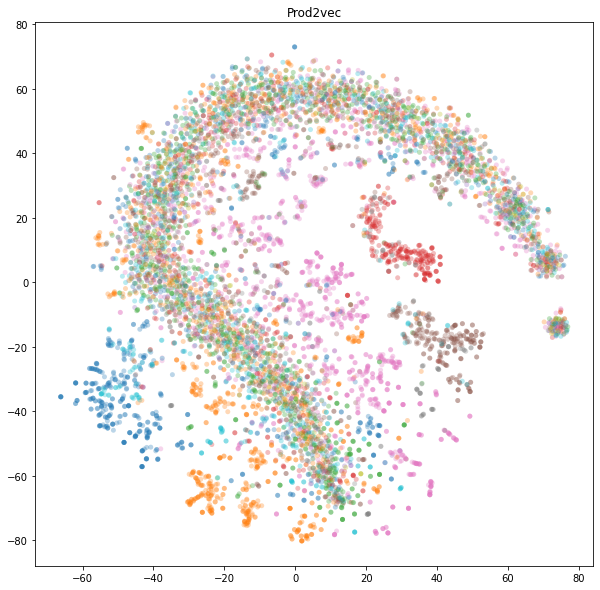

In [46]:
# print out tsne plot with standard params
tsne_results = tsne_analysis(embeddings)
assert len(tsne_results) == len(skus)
plot_scatter_by_category_with_lookup('Prod2vec', skus, sku_to_category, tsne_results)

In [47]:
# do a version with only top K categories
TOP_K = 5
cnt_categories = Counter(list(sku_to_category.values()))
top_categories = [c[0] for c in cnt_categories.most_common(TOP_K)]

Top SKUs # 4136
Total of # groups: 5


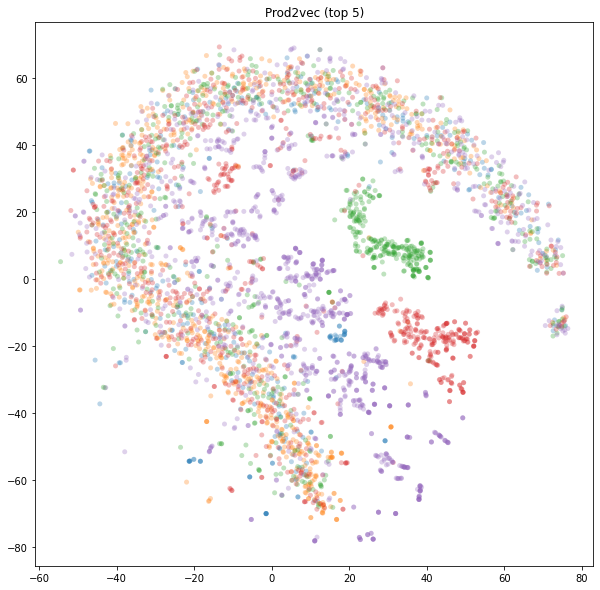

In [48]:
# filter out SKUs outside of top categories
top_skus = []
top_tsne_results = []
for _s, _t in zip(skus, tsne_results):
    if sku_to_category.get(_s, None) not in top_categories:
        continue
    top_skus.append(_s)
    top_tsne_results.append(_t)
# re-plot tsne with filtered SKUs
print("Top SKUs # {}".format(len(top_skus)))
plot_scatter_by_category_with_lookup('Prod2vec (top {})'.format(TOP_K), 
                                     top_skus, sku_to_category, top_tsne_results)

In [49]:
# Set up the model and vector that we are using in the comparison
annoy_index = AnnoyIndexer(prod2vec_model, 100)
test_sku = sku_cnt.most_common(1)[0][0]
# test all is good
print(prod2vec_model.most_similar([test_sku], topn=2, indexer=annoy_index))
print(prod2vec_model.most_similar([test_sku], topn=2))

[('093f87a220846c0c454de3ccb752bfe4ba00f94dfad925f0f1c5b56ca6033891', 1.0), ('55a3a145aa1c7541736794ece457cb6c52ddc71857fa78c3f841d48485481ff6', 0.9249290376901627)]
[('55a3a145aa1c7541736794ece457cb6c52ddc71857fa78c3f841d48485481ff6', 0.9887285828590393), ('710dc33ed61ae82db5ac89e11dfae101f168a35bc9f963aa887553c79e74f8b6', 0.9854732155799866)]


In [50]:
def avg_query_time(model, annoy_index=None, queries=5000):
    """Average query time of a most_similar method over random queries."""
    total_time = 0
    for _ in range(queries):
        _v = model[choice(model.index_to_key)]
        start_time = time.process_time()
        model.most_similar([_v], topn=5, indexer=annoy_index)
        total_time += time.process_time() - start_time
        
    return total_time / queries

gensim_time = avg_query_time(prod2vec_model)
annoy_time = avg_query_time(prod2vec_model, annoy_index=annoy_index)
print("Gensim (s/query):\t{0:.5f}".format(gensim_time))
print("Annoy (s/query):\t{0:.5f}".format(annoy_time))
speed_improvement = gensim_time / annoy_time
print ("\nAnnoy is {0:.2f} times faster on average on this particular run".format(speed_improvement))

Gensim (s/query):	0.00072
Annoy (s/query):	0.00015

Annoy is 4.69 times faster on average on this particular run


In [51]:
def calculate_HR_on_NEP(model, sessions, k=10, min_length=3):
    _count = 0
    _hits = 0
    for session in sessions:
        # consider only decently-long sessions
        if len(session) < min_length:
            continue
        # update the counter
        _count += 1
        # get the item to predict
        target_item = session[-1]
        # get model prediction using before-last item
        query_item = session[-2]
        # if model cannot make the prediction, it's a failure
        if query_item not in model:
            continue
        predictions = model.similar_by_word(query_item, topn=k)
        # debug
        # print(target_item, query_item, predictions)
        if target_item in [p[0] for p in predictions]:
            _hits += 1
    # debug
    print("Total test cases: {}".format(_count))
    
    return _hits / _count

In [52]:
# we simulate a test with 3 values for epochs in prod2ve
iterations_values = [1, 10]
# for each value we train a model, and use Next Event Prediction (NEP) to get a quality assessment
for i in iterations_values:
    print("\n ======> Hyper value: {}".format(i))
    cnt_model = train_product_2_vec_model(train_sessions, iterations=i)
    # use hold-out to have NEP performance
    _hr = calculate_HR_on_NEP(cnt_model, test_sessions)
    print("HR: {}\n".format(_hr))


 ======> Hyper value: 1
# products in the space: 7564
Total test cases: 2857
HR: 0.01575078753937697


 ======> Hyper value: 10
# products in the space: 7564
Total test cases: 2857
HR: 0.2569128456422821



## Improving low-count vectors

*prod2vec in the cold start scenario*

Know more - [paper](https://dl.acm.org/doi/10.1145/3383313.3411477), [video](https://vimeo.com/455641121)

In [53]:
def build_mapper(pro2vec_dims=48):
    """
    Build a Keras model for content-based "fake" embeddings.
    
    :return: a Keras model, mapping BERT-like catalog representations to the prod2vec space
    """
    # input
    description_input = Input(shape=(50,))
    image_input = Input(shape=(50,))
    # model
    x = Dense(25, activation="relu")(description_input)
    y = Dense(25, activation="relu")(image_input)
    combined = Concatenate()([x, y])
    combined = Dropout(0.3)(combined)
    combined = Dense(25)(combined)
    output = Dense(pro2vec_dims)(combined)

    return Model(inputs=[description_input, image_input], outputs=output)

In [55]:
# get vectors representing text and images in the catalog
def get_sku_to_embeddings_map(df):
    """
    For each SKU, get the text and image embeddings, as provided pre-computed by the dataset
    
    :return: dictionary, mapping SKU to a tuple of embeddings
    """
    sku_to_embeddings = dict()
    for _, row in df.iterrows():
        _sku = row['product_sku_hash']
        _description = row['description_vector']
        _image = row['image_vector']
        # skip when both vectors are not there
        if not _description or not _image:
            continue
        # if all good, store the mapping
        sku_to_embeddings[_sku] = (json.loads(_description), json.loads(_image))
            
    return sku_to_embeddings

In [56]:
sku_to_embeddings = get_sku_to_embeddings_map(sku_category)
print("Total of # {} SKUs with embeddings".format(len(sku_to_embeddings)))
# print out an example
_d, _i = sku_to_embeddings['438630a8ba0320de5235ee1bedf3103391d4069646d640602df447e1042a61a3']
print(len(_d), len(_i), _d[:5], _i[:5])

Total of # 28301 SKUs with embeddings
50 50 [0.4264949560165405, -0.03430507332086563, -0.16016942262649536, -0.02716980129480362, -0.056705817580223083] [155.99529135314958, 179.95122814519274, -122.27791561202048, -116.63741838098395, -129.55523589602947]


In [57]:
# just make sure we have the SKUs in the model and a counter
skus = prod2vec_model.index_to_key
print("Total of # {} skus in the model".format(len(skus)))
print(sku_cnt.most_common(5))

Total of # 7564 skus in the model
[('093f87a220846c0c454de3ccb752bfe4ba00f94dfad925f0f1c5b56ca6033891', 400), ('308d4a723466c68a87b151c8dd85533882595da0d5ffb26fcdd16535ff97dbee', 346), ('4ed32d7993879dd94130413cfaffe0e9d25a7321536687ae7ffed64ed1c76bd5', 299), ('aa8fe17953db2fd4b91cc468e43002fc6bab184165438e7ef371e020140334d8', 298), ('2ab1ba02f7ca5ec008fd4286405f1f1ef7ae86f144010c8d353e1d2dfbab5431', 298)]


Due to the long-tail of interactions, not all product vectors have the same quality. Plus, new products have no interactions!

**Solution - “Faking” high quality vectors through content**

1. First, we learn a mapping between meta-data and the space by using
popular products only.
2. Then, we apply the mapping to rare products and obtain new vectors! 

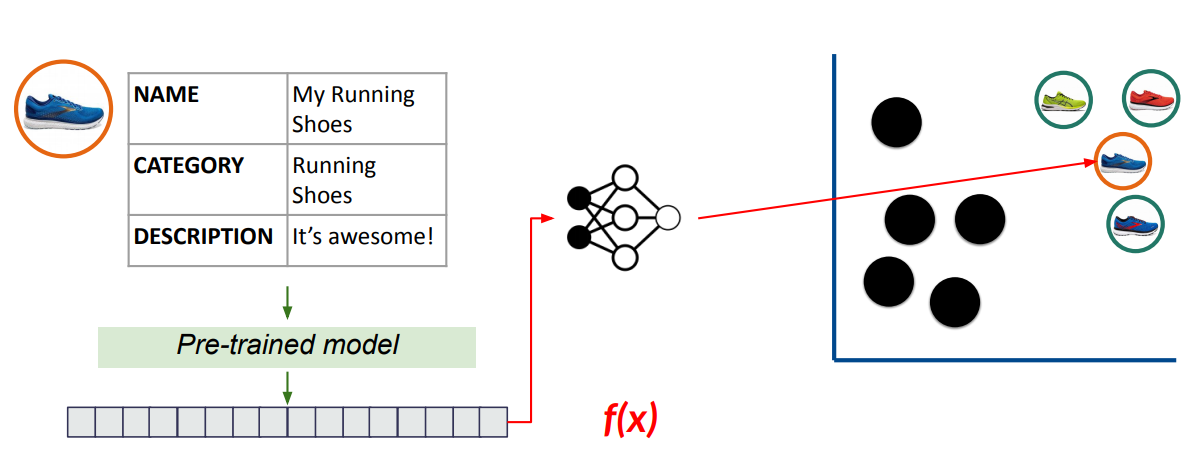

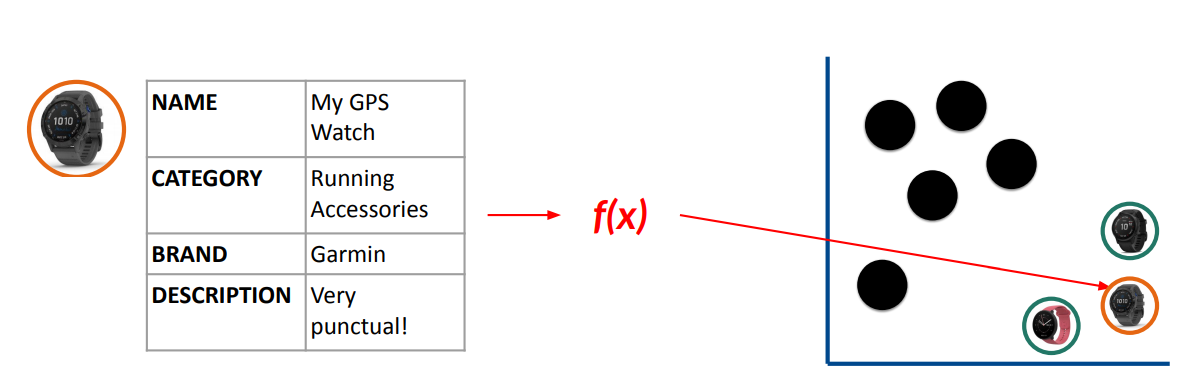

In [58]:
# above which percentile of frequency we consider SKU popular enough to be our training set?
FREQUENT_PRODUCTS_PTILE = 80

In [59]:
_counts = [c[1] for c in sku_cnt.most_common()]
_counts[:3]

[400, 346, 299]

In [60]:
# make sure we have just SKUS in the prod2vec space for which we have embeddings
popular_threshold = np.percentile(_counts, FREQUENT_PRODUCTS_PTILE)
popular_skus = [s for s in skus if s in sku_to_embeddings and sku_cnt.get(s, 0) > popular_threshold]
product_embeddings = [prod2vec_model[s] for s in popular_skus]
description_embeddings = [sku_to_embeddings[s][0] for s in popular_skus]
image_embeddings = [sku_to_embeddings[s][1] for s in popular_skus]
# debug
print(popular_threshold, len(skus), len(popular_skus))
# print(description_embeddings[:1][:3])
# print(image_embeddings[:1][:3])

11.0 7564 2691


In [61]:
# train the mapper now
training_data_X = [np.array(description_embeddings), np.array(image_embeddings)]
training_data_y = np.array(product_embeddings)

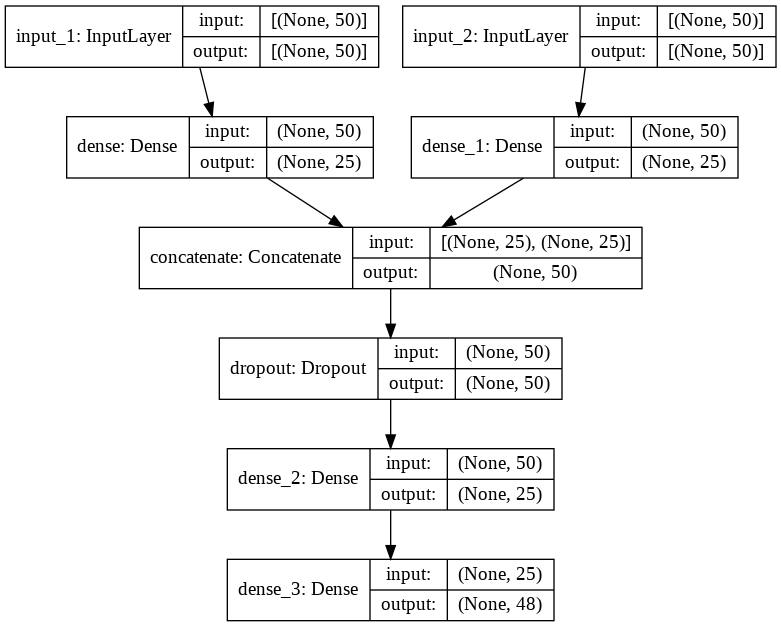

In [62]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights=True)
# build and display model
rare_net = build_mapper()
plot_model(rare_net, show_shapes=True, show_layer_names=True, to_file='rare_net.png')
Image('rare_net.png')

In [63]:
# train!
rare_net.compile(loss='mse', optimizer='rmsprop')
rare_net.fit(training_data_X, 
             training_data_y, 
             batch_size=200, 
             epochs=20000, 
             validation_split=0.2, 
             callbacks=[es])

Epoch 1/20000
11/11 [==============================] - 19s 69ms/step - loss: 1458.4166 - val_loss: 604.1883
Epoch 2/20000
11/11 [==============================] - 0s 5ms/step - loss: 798.6179 - val_loss: 392.0673
Epoch 3/20000
11/11 [==============================] - 0s 7ms/step - loss: 504.9096 - val_loss: 267.6727
Epoch 4/20000
11/11 [==============================] - 0s 5ms/step - loss: 348.9168 - val_loss: 185.1981
Epoch 5/20000
11/11 [==============================] - 0s 6ms/step - loss: 239.9646 - val_loss: 127.6391
Epoch 6/20000
11/11 [==============================] - 0s 7ms/step - loss: 163.8491 - val_loss: 87.9566
Epoch 7/20000
11/11 [==============================] - 0s 5ms/step - loss: 114.3901 - val_loss: 60.3418
Epoch 8/20000
11/11 [==============================] - 0s 5ms/step - loss: 79.0976 - val_loss: 41.4980
Epoch 9/20000
11/11 [==============================] - 0s 6ms/step - loss: 46.4890 - val_loss: 28.1266
Epoch 10/20000
11/11 [==============================] - 0s

In [64]:
# rarest_skus = [_[0] for _ in sku_cnt.most_common()[-500:]]
# test_skus = [s for s in rarest_skus if s in sku_to_embeddings]

# get to rare vectors
test_skus = [s for s in skus if s in sku_to_embeddings and sku_cnt.get(s, 0) < popular_threshold/2]
print(len(skus), len(test_skus))
# prepare embeddings for prediction
rare_description_embeddings = [sku_to_embeddings[s][0] for s in test_skus]
rare_image_embeddings = [sku_to_embeddings[s][1] for s in test_skus]

7564 2209


In [65]:
# prepare embeddings for prediction
test_data_X = [np.array(rare_description_embeddings), np.array(rare_image_embeddings)]
predicted_embeddings = rare_net.predict(test_data_X)
# debug
# print(len(predicted_embeddings))
# print(predicted_embeddings[0][:10])

In [66]:
def calculate_HR_on_NEP_rare(model, sessions, rare_skus, k=10, min_length=3):
    _count = 0
    _hits = 0
    _rare_hits = 0
    _rare_count = 0
    for session in sessions:
        # consider only decently-long sessions
        if len(session) < min_length:
            continue
        # update the counter
        _count += 1
        # get the item to predict
        target_item = session[-1]
        # get model prediction using before-last item
        query_item = session[-2]

        # if model cannot make the prediction, it's a failure
        if query_item not in model:
            continue
        
        # increment counter if rare sku
        if query_item in rare_skus:
            _rare_count+=1
        
        predictions = model.similar_by_word(query_item, topn=k)
    
        # debug
        # print(target_item, query_item, predictions)    
        if target_item in [p[0] for p in predictions]:
            _hits += 1
            # track hits if query is rare sku
            if query_item in rare_skus:
                _rare_hits+=1
    # debug
    print("Total test cases: {}".format(_count))
    print("Total rare test cases: {}".format(_rare_count))
    
    return _hits / _count, _rare_hits/_rare_count

In [67]:
# make copy of original prod2vec model
prod2vec_rare_model = deepcopy(prod2vec_model)
# update model with new vectors
prod2vec_rare_model.add_vectors(test_skus, predicted_embeddings, replace=True)
prod2vec_rare_model.fill_norms(force=True)
# check
assert np.array_equal(predicted_embeddings[0], prod2vec_rare_model[test_skus[0]])

# test new model
calculate_HR_on_NEP_rare(prod2vec_rare_model, test_sessions, test_skus)

Total test cases: 2857
Total rare test cases: 74


(0.28841442072103607, 0.02702702702702703)

In [68]:
# test original model
calculate_HR_on_NEP_rare(prod2vec_model, test_sessions, test_skus)

Total test cases: 2857
Total rare test cases: 74


(0.28911445572278616, 0.0945945945945946)

## Query scoping

Know more - [paper](https://www.aclweb.org/anthology/2020.ecnlp-1.2), [repo](https://github.com/jacopotagliabue/session-path)

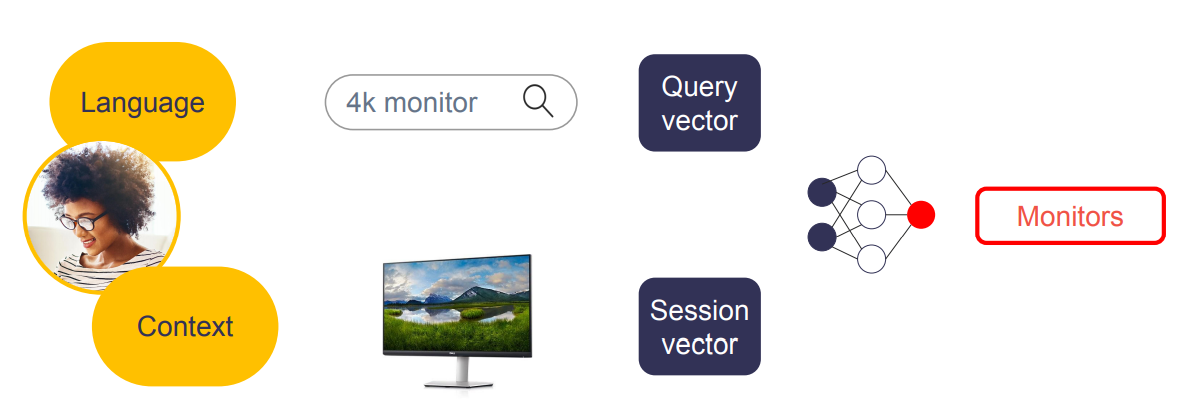

In [89]:
search_data = coveo_data.load_search_events()
search_data.head()

,SESSIONID,QUERY_VECTOR,ITEMID_CLICKED,ITEMID_VIEW,TIMESTAMP
0,1498632.0,"[-0.20255649089813232, -0.016908567398786545, ...",[nan],[nan],1548575194779
1,1498641.0,"[-0.007610442116856575, -0.14909175038337708, ...",[nan],"[1070.0, 3624.0, 8357.0]",1548276763869
2,1498647.0,"[-0.20023074746131897, -0.03151938319206238, 0...",[nan],"[17060.0, 5844.0, 5843.0, 23954.0, 16873.0, 17...",1548937997295
3,1498647.0,"[-0.18556387722492218, -0.07620412111282349, 0...",[nan],"[15247.0, 14067.0, 15246.0, 2934.0, 12346.0, 1...",1548938038268
4,1498647.0,"[-0.03269264101982117, -0.27234694361686707, 0...",[nan],"[87.0, 1271.0, 5017.0, 5478.0, 1260.0, 1259.0,...",1548938093827


In [90]:
# inverse_item_map = {v:k for k,v in labels['product_sku_hash'].items()}
search_data['SESSIONID'] = search_data['SESSIONID'].map(inverse_session_map)
search_data['ITEMID_VIEW'] = search_data['ITEMID_VIEW'].apply(lambda x: [inverse_item_map[y] for y in x if not np.isnan(y)])
search_data['ITEMID_CLICKED'] = search_data['ITEMID_CLICKED'].apply(lambda x: [inverse_item_map[y] for y in x if not np.isnan(y)])

search_data.columns = ['session_id_hash','query_vector','clicked_skus_hash',
                         'product_skus_hash','server_timestamp_epoch_ms']

# search_data.clicked_skus_hash = search_data.clicked_skus_hash.apply(lambda y: np.nan if len(y)==0 else y)
# search_data.product_skus_hash = search_data.product_skus_hash.apply(lambda y: np.nan if len(y)==0 else y)

search_data.head()

,session_id_hash,query_vector,clicked_skus_hash,product_skus_hash,server_timestamp_epoch_ms
0,48fade624d47870058ce07dd789ccc04e46c70c0fa2a1b...,"[-0.20255649089813232, -0.016908567398786545, ...",[],[],1548575194779
1,8731ca84ff7bb8cb647531d54e64feedb2519b4a7792a7...,"[-0.007610442116856575, -0.14909175038337708, ...",[],[9ee9ffd7e2529a65f9a0b0c9eaae6330df85cf2e3af33...,1548276763869
2,9be980708345944960645d03606ea83b637cae9106b705...,"[-0.20023074746131897, -0.03151938319206238, 0...",[],[7cc72dbed53bab78ec6a62feaa5052a7a1db7d201664b...,1548937997295
3,9be980708345944960645d03606ea83b637cae9106b705...,"[-0.18556387722492218, -0.07620412111282349, 0...",[],[62c4ddab6c1c81c74d315376b3c0dc7768c0286b3dc6f...,1548938038268
4,9be980708345944960645d03606ea83b637cae9106b705...,"[-0.03269264101982117, -0.27234694361686707, 0...",[],[2a0ee2924feabeec35e21e8fcb4d5b0684d190e46cef7...,1548938093827


In [92]:
xx = search_data.head()
xx

,session_id_hash,query_vector,clicked_skus_hash,product_skus_hash,server_timestamp_epoch_ms
0,48fade624d47870058ce07dd789ccc04e46c70c0fa2a1b...,"[-0.20255649089813232, -0.016908567398786545, ...",[],[],1548575194779
1,8731ca84ff7bb8cb647531d54e64feedb2519b4a7792a7...,"[-0.007610442116856575, -0.14909175038337708, ...",[],[9ee9ffd7e2529a65f9a0b0c9eaae6330df85cf2e3af33...,1548276763869
2,9be980708345944960645d03606ea83b637cae9106b705...,"[-0.20023074746131897, -0.03151938319206238, 0...",[],[7cc72dbed53bab78ec6a62feaa5052a7a1db7d201664b...,1548937997295
3,9be980708345944960645d03606ea83b637cae9106b705...,"[-0.18556387722492218, -0.07620412111282349, 0...",[],[62c4ddab6c1c81c74d315376b3c0dc7768c0286b3dc6f...,1548938038268
4,9be980708345944960645d03606ea83b637cae9106b705...,"[-0.03269264101982117, -0.27234694361686707, 0...",[],[2a0ee2924feabeec35e21e8fcb4d5b0684d190e46cef7...,1548938093827


In [103]:
from tensorflow.keras.utils import to_categorical

# get vectors representing text and images in the catalog
def get_query_to_category_dataset(df, cat_2_id, sku_to_category):
    """
    For each query, get a label representing the category in items clicked after the query.
    It uses as input a mapping "sku_to_category" to join the search file with catalog meta-data!
    
    :return: two lists, matching query vectors to a label
    """
    query_X = list()
    query_Y = list()
    for _, row in df.iterrows():
        _click_products = row['clicked_skus_hash']
        if not _click_products: # or _click_product not in sku_to_category:
            continue
        # clean the string and extract SKUs from array
        cleaned_skus = _click_products
        for s in cleaned_skus: 
            if s in sku_to_category:
                query_X.append(json.loads(row['query_vector']))
                target_category_as_int = cat_2_id[sku_to_category[s]]
                query_Y.append(to_categorical(target_category_as_int, num_classes=len(cat_2_id)))
            
    return query_X, query_Y

In [104]:
# sku_to_category = get_sku_to_category_map(sku_category)
print("Total of # {} categories".format(len(set(sku_to_category.values()))))
# cats = list(set(sku_to_category.values()))
# cat_2_id = {c: idx for idx, c in enumerate(cats)}
print(cat_2_id[cats[0]])
query_X, query_Y = get_query_to_category_dataset(search_data, 
                                                 cat_2_id,
                                                 sku_to_category)
print(len(query_X))
print(query_Y[0])

Total of # 40 categories
0
392083
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [105]:
x_train, x_test, y_train, y_test = train_test_split(np.array(query_X), np.array(query_Y), test_size=0.2)

In [106]:
def build_query_scoping_model(input_d, target_classes):
    print('Shape tensor {}, target classes {}'.format(input_d, target_classes))
    # define model
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=input_d))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(target_classes, activation='softmax'))
    
    return model

In [107]:
query_model = build_query_scoping_model(x_train[0].shape[0], y_train[0].shape[0])

Shape tensor 50, target classes 40


In [108]:
# compile model
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
query_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
# train first
query_model.fit(x_train, y_train, epochs=10, batch_size=32)
# compute and print eval score
score = query_model.evaluate(x_test, y_test, batch_size=32)
score

Epoch 1/10
9803/9803 [==============================] - 18s 2ms/step - loss: 2.0734 - accuracy: 0.3865
Epoch 2/10
9803/9803 [==============================] - 15s 2ms/step - loss: 1.5793 - accuracy: 0.5411
Epoch 3/10
9803/9803 [==============================] - 16s 2ms/step - loss: 1.4943 - accuracy: 0.5665
Epoch 4/10
9803/9803 [==============================] - 17s 2ms/step - loss: 1.4414 - accuracy: 0.5816
Epoch 5/10
9803/9803 [==============================] - 16s 2ms/step - loss: 1.4143 - accuracy: 0.5900
Epoch 6/10
9803/9803 [==============================] - 16s 2ms/step - loss: 1.3930 - accuracy: 0.5956
Epoch 7/10
9803/9803 [==============================] - 16s 2ms/step - loss: 1.3735 - accuracy: 0.6014
Epoch 8/10
9803/9803 [==============================] - 17s 2ms/step - loss: 1.3709 - accuracy: 0.6024
Epoch 9/10
9803/9803 [==============================] - 16s 2ms/step - loss: 1.3510 - accuracy: 0.6077
Epoch 10/10
2451/2451 [==============================] - 4s 1ms/step - lo

[1.0949926376342773, 0.6843668818473816]

In [115]:
browsing_data.head()

,session_id_hash,event_type,product_action,product_sku_hash,hashed_url,server_timestamp_epoch_ms
0,20c458b802f6ea9374783bfc528b19421be977a6769785...,event_product,detail,d5157f8bc52965390fa21ad5842a8502bc3eb8b0930f3f...,1550885210881,7e4527ac6a32deed4f4f06bb7c49b907b7ca371e59d57d...
1,20c458b802f6ea9374783bfc528b19421be977a6769785...,event_product,detail,61ef3869355b78e11011f39fc7ac8f8dfb209b3442a9d5...,1550885213307,4ed279f4f0deab6dfc80f4f7bf49d527fd894fa478a9ce...
2,20c458b802f6ea9374783bfc528b19421be977a6769785...,pageview,NaN,NaN,1550885213307,4ed279f4f0deab6dfc80f4f7bf49d527fd894fa478a9ce...
3,20c458b802f6ea9374783bfc528b19421be977a6769785...,event_product,detail,d5157f8bc52965390fa21ad5842a8502bc3eb8b0930f3f...,1550885215484,7e4527ac6a32deed4f4f06bb7c49b907b7ca371e59d57d...
4,20c458b802f6ea9374783bfc528b19421be977a6769785...,pageview,NaN,NaN,1550885215484,7e4527ac6a32deed4f4f06bb7c49b907b7ca371e59d57d...


In [113]:
# get vectors representing text and images in the catalog
def get_query_info(df):
    """
    For each query, extract relevant metadata of query and to match with session data

    :return: list of queries with metadata
    """
    queries = list()
    for _, row in df.iterrows():
        _click_products = row['clicked_skus_hash']
        if not _click_products: # or _click_product not in sku_to_category:
            continue
        # clean the string and extract SKUs from array
        cleaned_skus = _click_products
        queries.append({'session_id_hash' : row['session_id_hash'],
                        'server_timestamp_epoch_ms' : int(row['server_timestamp_epoch_ms']),
                        'clicked_skus' : cleaned_skus,
                        'query_vector' : json.loads(row['query_vector'])})
    print("# total queries: {}".format(len(queries)))        
    
    return queries

def get_session_info_for_queries(df: str, query_info: list, K: int = None):
    """
    Read the training file containing product interactions for sessions with query, up to K rows.
    
    :return: dict of lists with session_id as key, each list being a session (sequence of product events with metadata) 
    """
    user_sessions = dict()
    current_session_id = None
    current_session = []
    
    query_session_ids = set([ _['session_id_hash'] for _ in query_info])

    for idx, row in df.iterrows():
        # just append "detail" events in the order we see them
        # row will contain: session_id_hash, product_action, product_sku_hash
        _session_id_hash = row['session_id_hash']
        # when a new session begins, store the old one and start again
        if current_session_id and current_session and _session_id_hash != current_session_id:
            user_sessions[current_session_id] = current_session
            # reset session
            current_session = []
        # check for the right type and append event info
        if row['product_action'] == 'detail' and _session_id_hash in query_session_ids :
            current_session.append({'product_sku_hash': row['product_sku_hash'],
                                    'server_timestamp_epoch_ms' : int(row['server_timestamp_epoch_ms'])})
        # update the current session id
        current_session_id = _session_id_hash

    # print how many sessions we have...
    print("# total sessions: {}".format(len(user_sessions)))


    return dict(user_sessions)

In [117]:
query_info = get_query_info(search_data)
session_info = get_session_info_for_queries(browsing_data.head(N_ROWS), query_info)

# total sessions: 1490


In [121]:
def get_contextual_query_to_category_dataset(query_info, session_info, prod2vec_model, cat_2_id, sku_to_category):
    """
    For each query, get a label representing the category in items clicked after the query.
    It uses as input a mapping "sku_to_category" to join the search file with catalog meta-data!
    It also creates a joint embedding for input by concatenating query vector and average session vector up till
    when query was made
    
    :return: two lists, matching query vectors to a label
    """
    query_X = list()
    query_Y = list()
    
    for row in query_info:
        query_timestamp = row['server_timestamp_epoch_ms']
        cleaned_skus = row['clicked_skus']
        session_id_hash = row['session_id_hash']
        if session_id_hash not in session_info or not cleaned_skus: # or _click_product not in sku_to_category:
            continue            
            
        session_skus = session_info[session_id_hash]
        context_skus = [ e['product_sku_hash'] for e in session_skus if query_timestamp > e['server_timestamp_epoch_ms'] 
                                                                        and e['product_sku_hash'] in prod2vec_model]
        if not context_skus:
            continue
        context_vector = np.mean([prod2vec_model[sku] for sku in context_skus], axis=0).tolist()
        for s in cleaned_skus: 
            if s in sku_to_category:
                query_X.append(row['query_vector'] + context_vector)
                target_category_as_int = cat_2_id[sku_to_category[s]]
                query_Y.append(to_categorical(target_category_as_int, num_classes=len(cat_2_id)))
            
    return query_X, query_Y

In [122]:
context_query_X, context_query_Y = get_contextual_query_to_category_dataset(query_info, 
                                                                            session_info, 
                                                                            prod2vec_model, 
                                                                            cat_2_id, 
                                                                            sku_to_category)
print(len(context_query_X))
print(context_query_Y[0])

2165
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [123]:
x_train, x_test, y_train, y_test = train_test_split(np.array(context_query_X), np.array(context_query_Y), test_size=0.2)

In [124]:
contextual_query_model = build_query_scoping_model(x_train[0].shape[0], y_train[0].shape[0])

Shape tensor 98, target classes 40


In [125]:
# compile model
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
contextual_query_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
# train first
contextual_query_model.fit(x_train, y_train, epochs=10, batch_size=32)
# compute and print eval score
score = contextual_query_model.evaluate(x_test, y_test, batch_size=32)
score

Epoch 1/10
55/55 [==============================] - 1s 3ms/step - loss: 3.5645 - accuracy: 0.1072
Epoch 2/10
55/55 [==============================] - 0s 2ms/step - loss: 2.4727 - accuracy: 0.2924
Epoch 3/10
55/55 [==============================] - 0s 2ms/step - loss: 2.2572 - accuracy: 0.3278
Epoch 4/10
55/55 [==============================] - 0s 2ms/step - loss: 2.1380 - accuracy: 0.3685
Epoch 5/10
55/55 [==============================] - 0s 2ms/step - loss: 2.0003 - accuracy: 0.4019
Epoch 6/10
55/55 [==============================] - 0s 2ms/step - loss: 2.0015 - accuracy: 0.4011
Epoch 7/10
55/55 [==============================] - 0s 2ms/step - loss: 1.9685 - accuracy: 0.4342
Epoch 8/10
55/55 [==============================] - 0s 2ms/step - loss: 1.8872 - accuracy: 0.4554
Epoch 9/10
55/55 [==============================] - 0s 2ms/step - loss: 1.8276 - accuracy: 0.4639
Epoch 10/10
14/14 [==============================] - 0s 2ms/step - loss: 1.6339 - accuracy: 0.5266


[1.6338858604431152, 0.5265588760375977]

## References

* ["An Image is Worth a Thousand Features": Scalable Product Representations for In-Session Type-Ahead Personalization](https://dl.acm.org/doi/10.1145/3366424.3386198)
* [Fantastic Embeddings and How to Align Them: Zero-Shot Inference in a Multi-Shop Scenario](https://arxiv.org/abs/2007.14906)
* [Shopping in the Multiverse: A Counterfactual Approach to In-Session Attribution](https://arxiv.org/pdf/2007.10087.pdf)
* [The Embeddings That Came in From the Cold: Improving Vectors for New and Rare Products with Content-Based Inference](https://dl.acm.org/doi/10.1145/3383313.3411477)
* [How to Grow a (Product) Tree: Personalized Category Suggestions for eCommerce Type-Ahead](https://www.aclweb.org/anthology/2020.ecnlp-1.2/)